# External Evaluation and Error Analysis
This notebook evaluates the **generalisation performance** of trained models on an **unseen real-world dataset** (`in the wild`) and performs **error analysis** on the best-performing model.

## What this notebook covers: 
- Loads models trained on the `for-norm` dataset
- Applies them to the **release-in-the-wild** dataset
- Confusion Matrix (Best Model):
    - Visualises performance for the selected model
- Error Analysis:
    - Compares **False Negatives** (misclassified fake audios) with **True Positives**
- Explores:
  - Feature distributions
  - Audio duration distribution

In [1]:
# Importing required libraries
import os
import librosa
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load in-the-wild features
df_wild = pd.read_csv("Processed_Features/release_in_wild_features.csv")

# Separate features and labels
X_wild = df_wild.drop(columns=["filename", "label", "LABEL"])
y_wild = df_wild["LABEL"]

# Load saved scaler from training phase
scaler = joblib.load("saved_models/for_norm_scaler.joblib")
X_wild_scaled = scaler.transform(X_wild)

# Load all saved models
model_names = ["LogisticRegression", "NaiveBayes", "DecisionTree", "RandomForest", "SVM"]
loaded_models = {
    name: joblib.load(f"saved_models/{name}_for_norm.joblib") for name in model_names
}

In [3]:
# A function to extract metrics from classifiction report
def get_metrics(y_true, y_pred, dataset_name, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    
    return {
        "Model": model_name,
        "Dataset": dataset_name,
        "Precision_0": report['0']['precision'],
        "Recall_0": report['0']['recall'],
        "F1_0": report['0']['f1-score'],
        "Support_0": report['0']['support'],
        "Precision_1": report['1']['precision'],
        "Recall_1": report['1']['recall'],
        "F1_1": report['1']['f1-score'],
        "Support_1": report['1']['support'],
        "Accuracy": accuracy_score(y_true, y_pred),
    }

In [4]:
# Evaluate the models and store predictions
external_results = []
external_predictions = {}  # To store predictions for confusion matrix

for name, model in loaded_models.items():
    y_pred = model.predict(X_wild_scaled)
    external_predictions[name] = y_pred  # Save for confusion matrix
    external_results.append(get_metrics(y_wild, y_pred, "External (release-in-the-wild)", name))

# Convert to DataFrame
external_df = pd.DataFrame(external_results)
external_df.to_csv("release_in_wild_external_results.csv", index=False)
display(external_df)

,Model,Dataset,Precision_0,Recall_0,F1_0,Support_0,Precision_1,Recall_1,F1_1,Support_1,Accuracy
0,LogisticRegression,External (release-in-the-wild),0.676255,0.194990,0.302700,11816.0,0.664740,0.944748,0.780387,19963.0,0.665974
1,NaiveBayes,External (release-in-the-wild),0.512054,0.134817,0.213439,11816.0,0.643400,0.923959,0.758570,19963.0,0.630542
2,DecisionTree,External (release-in-the-wild),0.551465,0.434834,0.486254,11816.0,0.702698,0.790663,0.744090,19963.0,0.658359
3,RandomForest,External (release-in-the-wild),0.515152,0.011510,0.022517,11816.0,0.629383,0.993588,0.770620,19963.0,0.628434
4,SVM,External (release-in-the-wild),0.647463,0.063727,0.116034,11816.0,0.638653,0.979462,0.773167,19963.0,0.638975


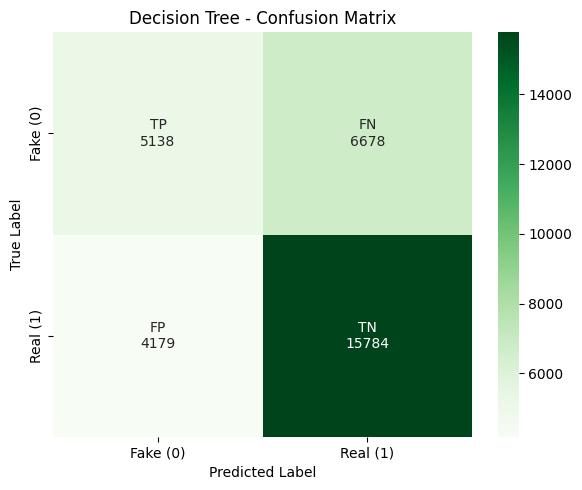

In [5]:
# Get Decision Tree predictions (best performing model)
dt_preds = external_predictions["DecisionTree"]

# Compute confusion matrix
cm = confusion_matrix(y_wild, dt_preds)

# Function to label the matrix
def label_conf_matrix(matrix):
    labels = np.array([["TP", "FN"], ["FP", "TN"]])
    return labels

# Format matrix with labels
labels = label_conf_matrix(cm)
annot = np.array([[f"{label}\n{count}" for label, count in zip(row_l, row_c)]
                  for row_l, row_c in zip(labels, cm)])

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=annot, fmt="", cmap="Greens", 
            xticklabels=["Fake (0)", "Real (1)"], yticklabels=["Fake (0)", "Real (1)"])
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


## Error Analysis: False Negatives vs True Positives (Fake Class Only)

Decision Tree predictions saved


Calculating durations for TP: 100%|██████████| 5138/5138 [00:01<00:00, 4064.29it/s]


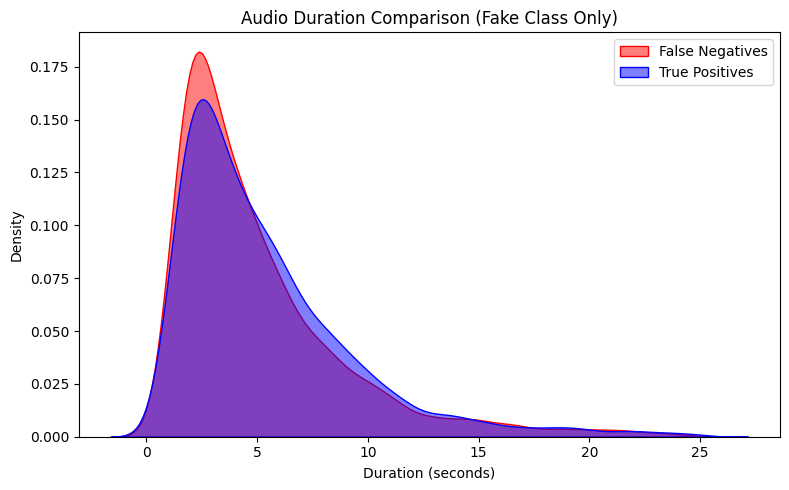

In [9]:
# Attach predictions to the dataset
df_wild_copy = df_wild.copy()
df_wild_copy["y_true"] = y_wild
df_wild_copy["y_pred"] = dt_preds  # Predictions from the Decision Tree

# Save predictions for reuse later
df_wild_copy.to_csv("decision_tree_predictions.csv", index=False)
print("Decision Tree predictions saved")

# Filter False Negatives (Fake -> Real) and True Positives (Fake -> Fake)
false_negatives = df_wild_copy[(df_wild_copy["y_true"] == 0) & (df_wild_copy["y_pred"] == 1)].copy()
true_positives = df_wild_copy[(df_wild_copy["y_true"] == 0) & (df_wild_copy["y_pred"] == 0)].copy()

# Define path to fake audio folder
fake_audio_folder = "data/processed_data/fake"

# Function to get audio duration
def get_audio_duration(filename):
    path = os.path.join(fake_audio_folder, filename)
    try:
        y, sr = librosa.load(path, sr=None)
        return librosa.get_duration(y=y, sr=sr)
    except Exception:
        return None

# Add durations using tqdm progress bar
tqdm.pandas(desc="Calculating durations for FN")
false_negatives.loc[:, "duration"] = false_negatives["filename"].progress_apply(get_audio_duration)

tqdm.pandas(desc="Calculating durations for TP")
true_positives.loc[:, "duration"] = true_positives["filename"].progress_apply(get_audio_duration)

# Drop missing durations (e.g., errors)
false_negatives = false_negatives.dropna(subset=["duration"])
true_positives = true_positives.dropna(subset=["duration"])

# Plot duration comparison (KDE)
plt.figure(figsize=(8, 5))
sns.kdeplot(false_negatives["duration"], label="False Negatives", fill=True, color="red", alpha=0.5)
sns.kdeplot(true_positives["duration"], label="True Positives", fill=True, color="blue", alpha=0.5)
plt.title("Audio Duration Comparison (Fake Class Only)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

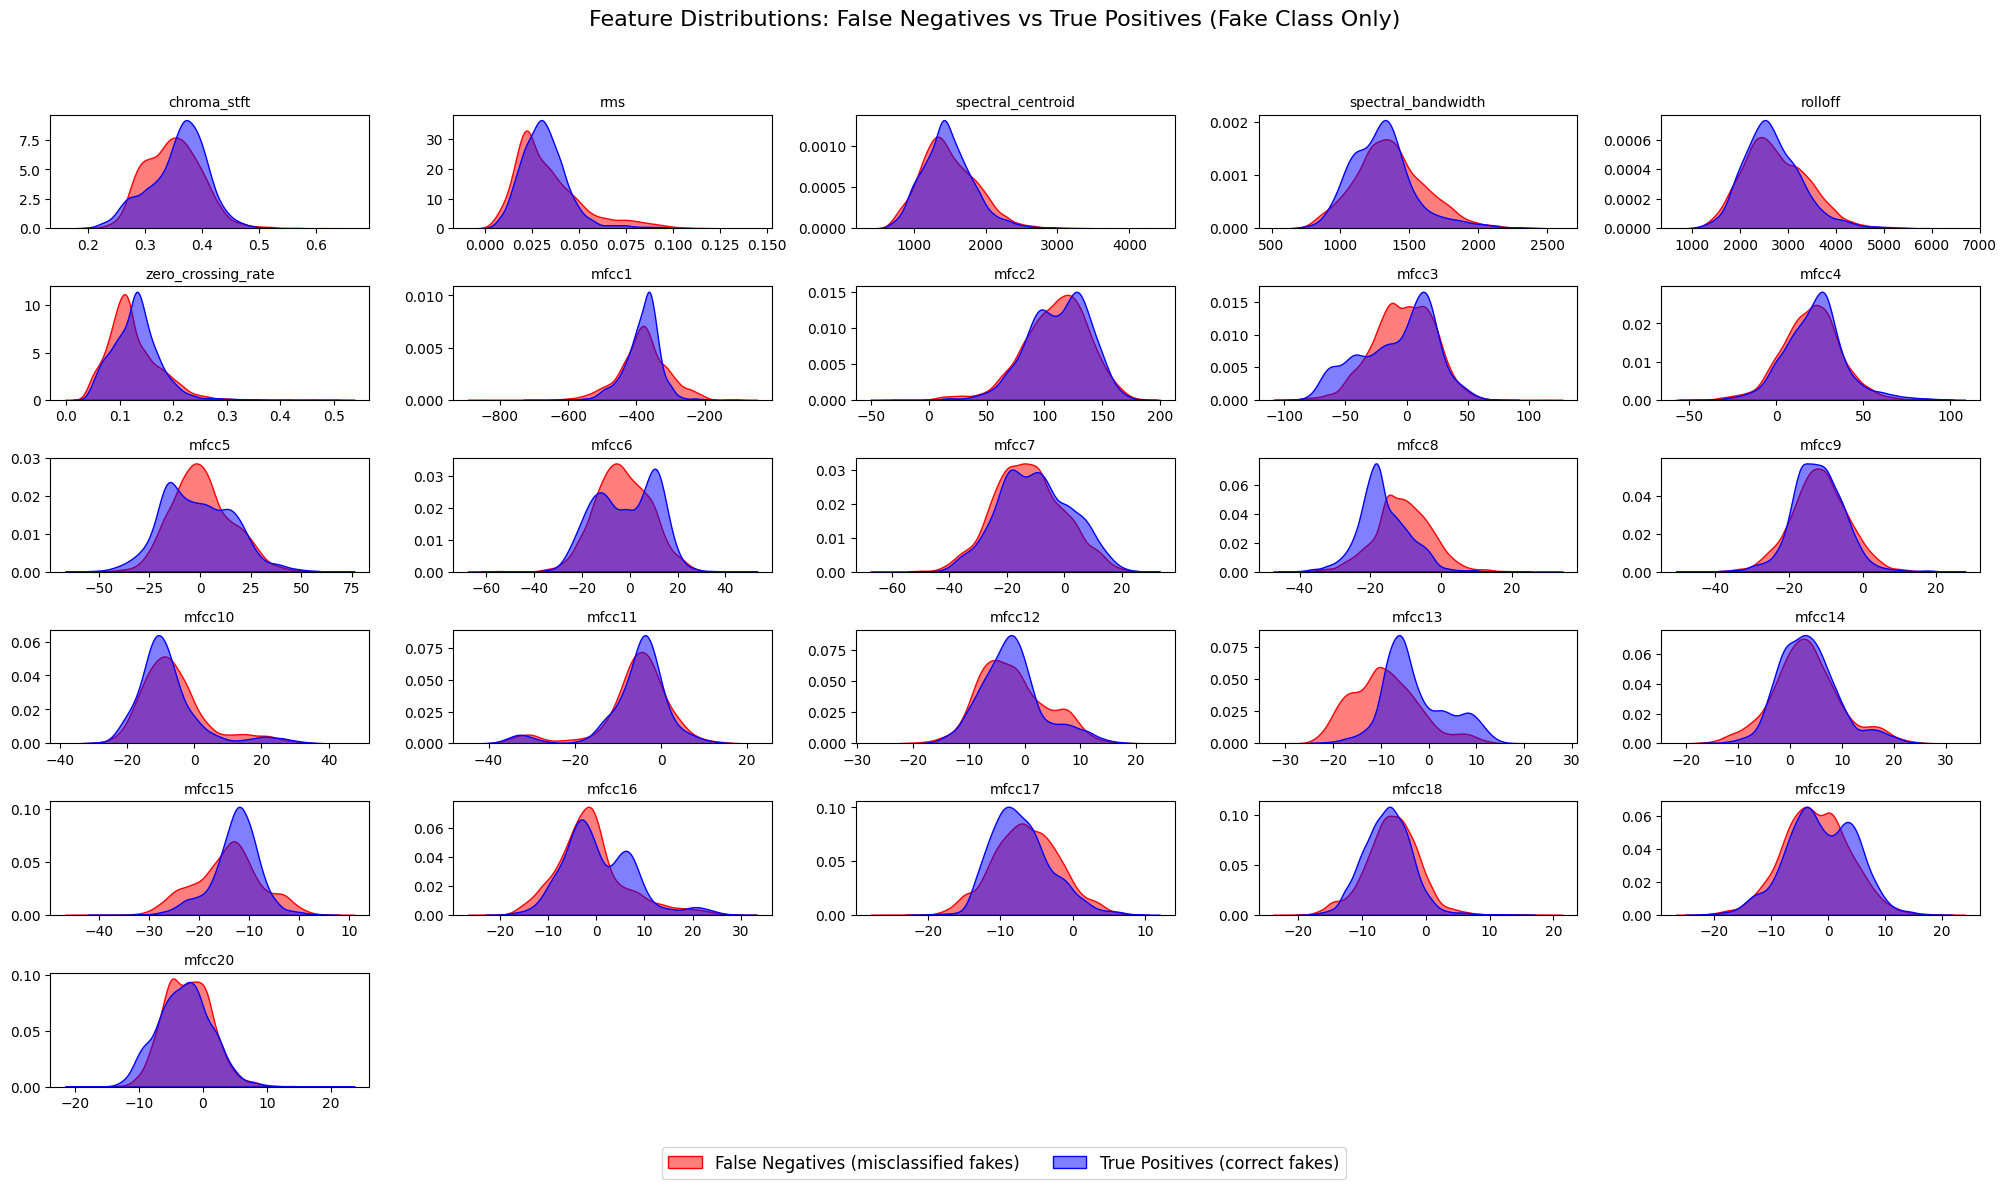

In [8]:
# Plot feature distributions (KDE) for selected features
base_features = ["chroma_stft", "rms", "spectral_centroid", "spectral_bandwidth", 
                 "rolloff", "zero_crossing_rate"]
mfcc_features = [f"mfcc{i}" for i in range(1, 21)]
all_features = base_features + mfcc_features

n_cols = 5
n_rows = (len(all_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.flatten()

for i, feature in enumerate(all_features):
    sns.kdeplot(false_negatives[feature], label="FN", fill=True, color="red", alpha=0.5, ax=axes[i])
    sns.kdeplot(true_positives[feature], label="TP", fill=True, color="blue", alpha=0.5, ax=axes[i])
    axes[i].set_title(feature, fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    if axes[i].get_legend():
        axes[i].legend_.remove()

# Remove unused axes
for j in range(len(all_features), len(axes)):
    fig.delaxes(axes[j])

fig.legend(["False Negatives (misclassified fakes)", "True Positives (correct fakes)"], 
           loc="lower center", ncol=2, fontsize=12)
fig.suptitle("Feature Distributions: False Negatives vs True Positives (Fake Class Only)", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()
